# Import

In [441]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 199)

from datetime import datetime
import re
import os
import os.path
import math
import sys
import csv
import glob
import seaborn as sns
import numpy as np
import shap 
from collections import Counter

# import mlflow
# import mlflow.sklearn
# import pysftp

from sklearn.metrics import confusion_matrix
import seaborn as sns
pd.options.display.float_format = "{:.2f}".format

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm 

import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss, roc_auc_score, f1_score

%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/utils.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/visualization/common_visualization.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/common_eda.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/modelling/regression_model.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/common_dictionary.py"

print("current working folder: ", os.getcwd())
user_name = "chaupham"
# print("notebook kernel id: ", get_notebook_kernel_id())

current working folder:  /Users/chau/minhchau/jupyter_projects/plant_project


# Helper funcs

In [442]:
def convert_to_up_down_noChange_2(x, thres, c, base_col):
    if x[c] / x[base_col] > thres:  ##UP
        return "2"
    elif x[c] / x[base_col] < 1/thres:
        return  "1" ## DOWN
    else:
        return "0" # NO_CHANGE
    
def convert_to_up_down_noChange_3(x, thres, c, base_col):
    if np.log2(x[c] / x[base_col] )> thres:  ##UP
        return "2"
    elif np.log2(x[c] / x[base_col]) < -thres:
        return  "1" ## DOWN
    else:
        return "0" # NO_CHANGE

In [443]:
def convert_to_up_down_noChange(x, thres, c, base_col):
    if x[c] - x[base_col] > thres:  ##UP
        return "2"
    elif x[c] + thres < x[base_col]:
        return  "1" ## DOWN
    else:
        return "0" # NO_CHANGE

# Read input

In [444]:
up_down_target=pd.read_csv("./data/Targets_differentially_expressed.csv")

up_down_target_list = set(up_down_target['TARGETS|upregulated']).union(set(up_down_target['TARGETS|downregulated'])).union( set(up_down_target['TARGETS|up|down']) )
up_down_target_list.remove(np.nan)
print(len(up_down_target_list))

294


In [445]:
STOP1="AT1G34370"

In [533]:
df = pd.read_csv("./data/cleaned_data.csv")
df.shape                 

(20450, 14)

In [534]:
df.label.value_counts()

0    19245
1     1205
Name: label, dtype: int64

In [535]:
df.head()

,atID,wthp6,wthp6_2,wtlp6,wtlp6_2,wthp5,wthp5_2,wtlp5,wtlp5_2,wtal,wtal_2,wtfe,wtfe_2,label
0,AT1G01020,18.51,17.60,17.80,20.36,18.99,21.93,18.29,21.48,19.01,17.58,18.21,18.19,0
1,AT1G01030,0.82,1.07,0.68,0.45,0.54,0.40,0.56,0.29,0.22,0.81,0.93,0.62,1
2,AT1G01040,36.57,34.09,31.92,53.51,37.06,34.78,43.44,49.22,42.09,36.11,32.94,17.10,0
3,AT1G01050,103.58,109.89,103.21,96.22,100.88,106.00,97.60,100.95,89.76,92.77,91.97,112.10,0
4,AT1G01060,1.94,1.78,2.93,2.88,3.15,3.67,2.44,2.13,1.34,1.89,3.52,1.89,1


In [536]:
wt_cols = ['wthp6', 'wtlp6',  'wthp5',  'wtlp5',  'wtal',  'wtfe']
wt_conditioned_cols = wt_cols[1:]
base_col= wt_cols[0]
wt_BIT_cols = [c+"_BIT" for c in wt_conditioned_cols]

for c in wt_cols:
    df[c + "_ave"] = (df[c] + df[c + "_2"]) / 2
    
df.columns

Index(['atID', 'wthp6', 'wthp6_2', 'wtlp6', 'wtlp6_2', 'wthp5', 'wthp5_2', 'wtlp5', 'wtlp5_2',
       'wtal', 'wtal_2', 'wtfe', 'wtfe_2', 'label', 'wthp6_ave', 'wtlp6_ave', 'wthp5_ave',
       'wtlp5_ave', 'wtal_ave', 'wtfe_ave'],
      dtype='object')

In [537]:
data_df = df[['atID', 'label', 'wthp6_ave', 'wtlp6_ave', 'wthp5_ave', 'wtlp5_ave', 'wtal_ave', 'wtfe_ave']]
data_df.columns = ['atID', 'label', 'wthp6', 'wtlp6', 'wthp5', 'wtlp5', 'wtal', 'wtfe']

In [538]:
data_df.head()

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe
0,AT1G01020,0,18.06,19.08,20.46,19.88,18.30,18.20
1,AT1G01030,1,0.94,0.57,0.47,0.43,0.52,0.77
2,AT1G01040,0,35.33,42.71,35.92,46.33,39.10,25.02
3,AT1G01050,0,106.73,99.72,103.44,99.28,91.26,102.04
4,AT1G01060,1,1.86,2.91,3.41,2.29,1.61,2.71


In [476]:
def get_L1_raw(x):
    return sum(np.abs([x[c] - x[base_col] for c in wt_conditioned_cols]))
    
def get_L2_raw(x):
    return math.sqrt(np.square([x[c] - x[base_col] for c in wt_conditioned_cols]))
    
def get_L1_norm(x):
    max_x = np.amax(x[wt_cols])
    x[wt_cols] = x[wt_cols]/max_x
    return get_L1_raw(x)

def get_L2_norm(x):
    max_x = np.amax(x[wt_cols])
    x[wt_cols] = x[wt_cols]/max_x
    return get_L2_raw(x)

def get_L1_Log2Fold(x):
    return sum(np.abs( np.log2([x[c] / x[base_col] for c in wt_conditioned_cols])) )

def get_L2_Log2Fold(x):
    return np.sum(np.square( np.log2([x[c] / x[base_col] for c in wt_conditioned_cols])) )


def get_L2_noLog2(x):
    return np.sum(np.square( [x[c] / x[base_col] for c in wt_conditioned_cols])) 

# Filter out wt(s)==0

In [453]:
for c in wt_cols:
    tmp = data_df[data_df[c] == 0]
    print(f"Shape before removing: {df.shape[0]};\nThere is {tmp.shape[0]} obs having {c}==0, in which {tmp[tmp.label == 1].shape[0]} are class_1")
    data_df = data_df[data_df[c] != 0]
data_df.shape

Shape before removing: 20450;
There is 38 obs having wthp6==0, in which 2 are class_1
Shape before removing: 20450;
There is 33 obs having wtlp6==0, in which 2 are class_1
Shape before removing: 20450;
There is 11 obs having wthp5==0, in which 1 are class_1
Shape before removing: 20450;
There is 17 obs having wtlp5==0, in which 1 are class_1
Shape before removing: 20450;
There is 7 obs having wtal==0, in which 0 are class_1
Shape before removing: 20450;
There is 12 obs having wtfe==0, in which 2 are class_1


(20332, 8)

In [477]:
data_df["L1_raw"] = data_df.apply(get_L1_raw, 1)
data_df["L2_log2fold"] = data_df.apply(get_L2_Log2Fold, 1)
data_df["L2_noLog2"] = data_df.apply(get_L2_noLog2, 1)

data_df.head()

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe,L2_log2fold,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,group_id,L1_raw,L2_noLog2
0,AT1G01020,0,18.06,19.08,20.46,19.88,18.30,18.20,0.06,0,2,2,0,0,02200,5.63,5.66
1,AT1G01030,1,0.94,0.57,0.47,0.43,0.52,0.77,3.66,1,1,1,1,1,11111,1.95,1.79
2,AT1G01040,0,35.33,42.71,35.92,46.33,39.10,25.02,0.50,2,0,2,2,1,20221,33.07,5.94
3,AT1G01050,0,106.73,99.72,103.44,99.28,91.26,102.04,0.08,0,0,1,1,0,00110,37.93,4.32
4,AT1G01060,1,1.86,2.91,3.41,2.29,1.61,2.71,1.61,2,2,2,1,2,22212,4.12,10.20


count   20332.00
mean       50.59
std       165.03
min         0.02
0%          0.02
5%          1.00
10%         1.85
15%         3.02
20%         4.39
25%         6.05
30%         8.00
35%        10.10
40%        12.40
45%        14.99
50%        18.03
55%        21.52
60%        25.50
65%        30.16
70%        36.28
75%        43.85
80%        53.88
85%        70.18
90%       102.52
95%       186.12
max     13493.21
Name: wtfe, dtype: float64


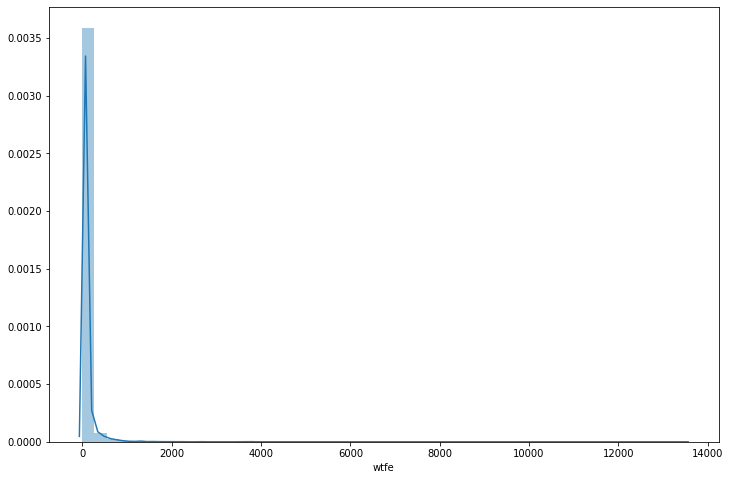

In [506]:
percentile(data_df[c])

wthp6
AUC = 0.42069185244270857
max of class_1 = 324.7421649500001


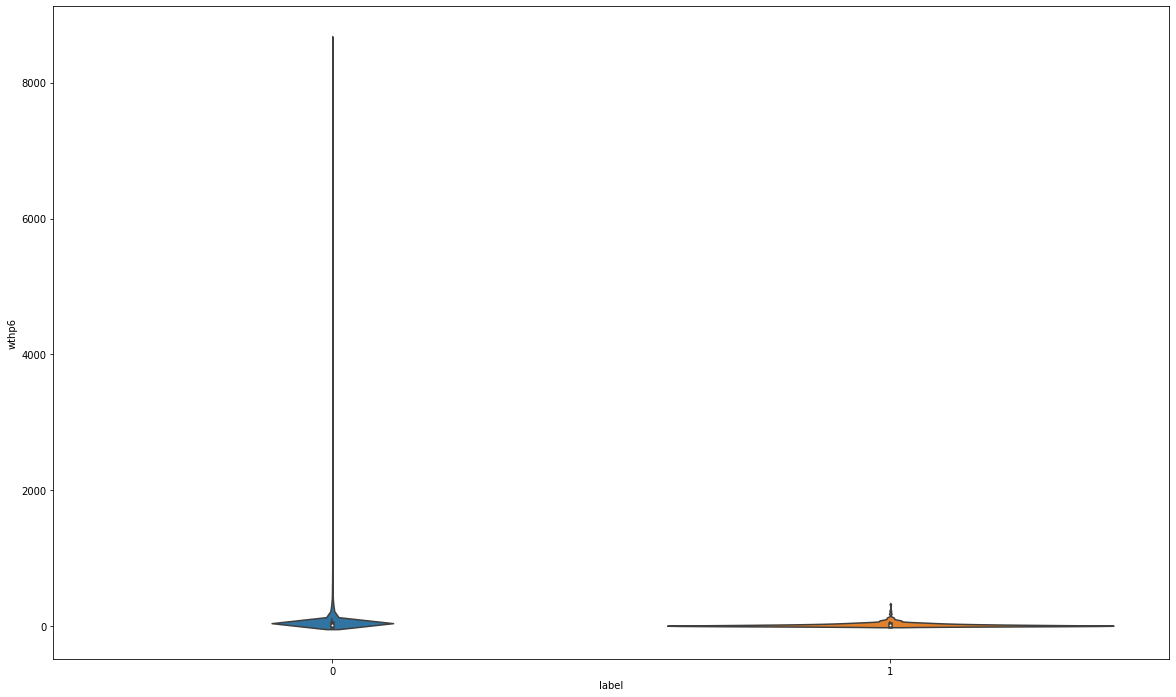

wtlp6
AUC = 0.4227077361551252
max of class_1 = 312.31847235


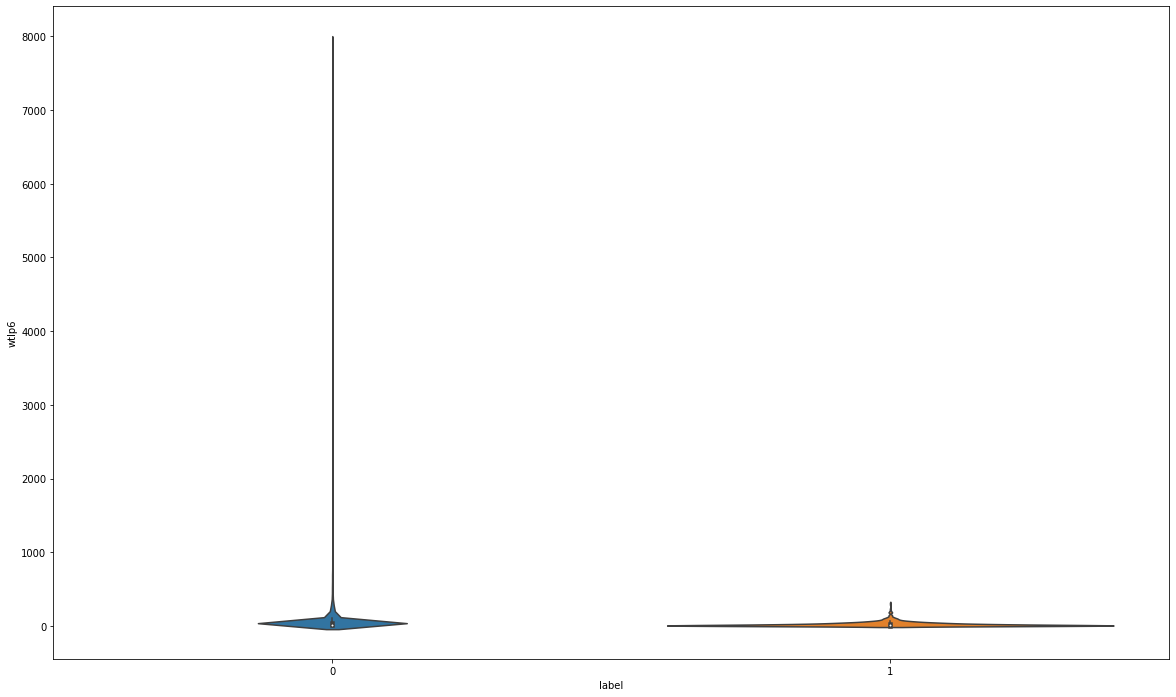

wthp5
AUC = 0.42212521112030144
max of class_1 = 342.69084250000003


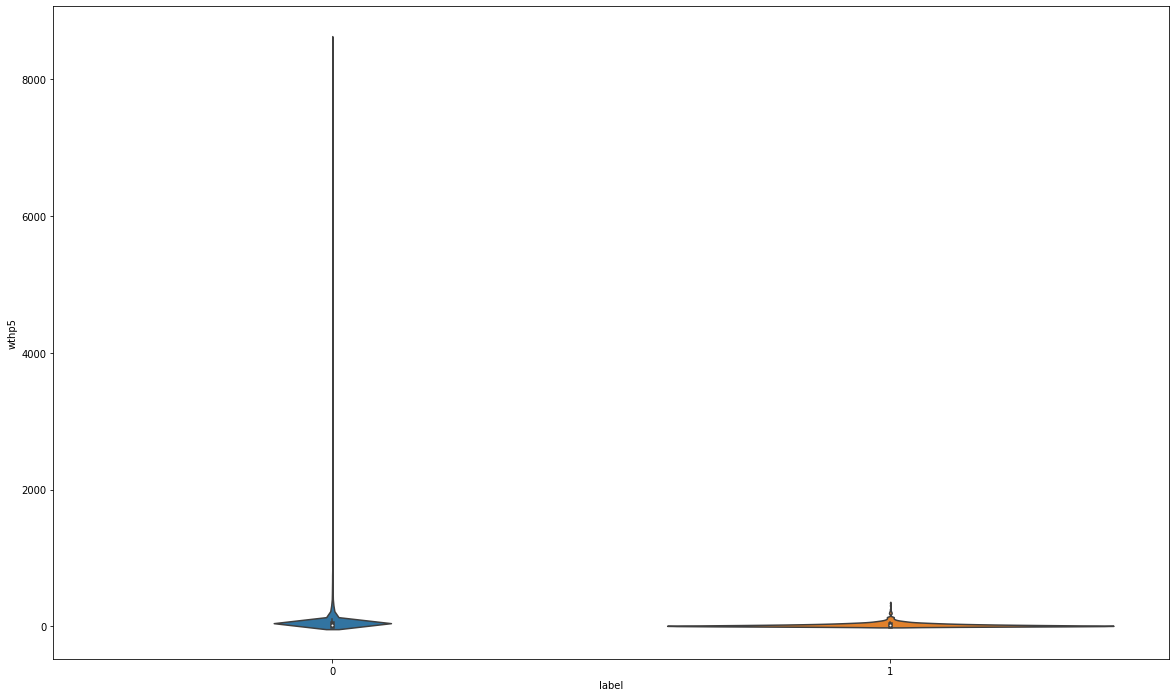

wtlp5
AUC = 0.4228541478249233
max of class_1 = 313.73594845


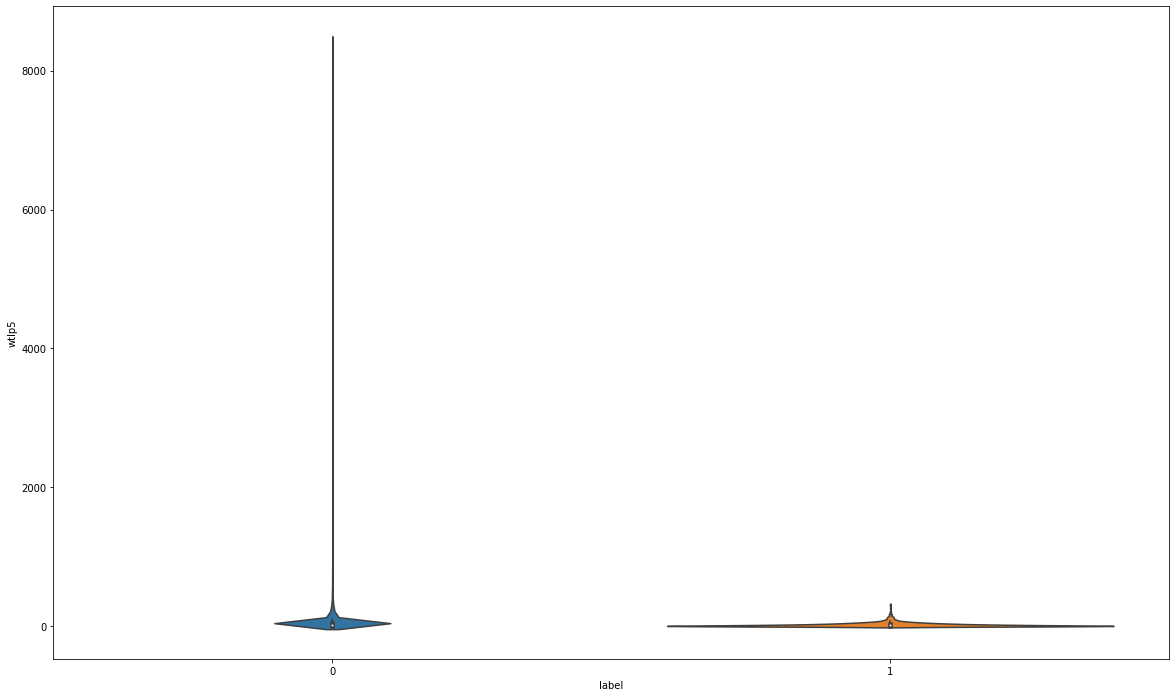

wtal
AUC = 0.4256753066360701
max of class_1 = 325.4185606


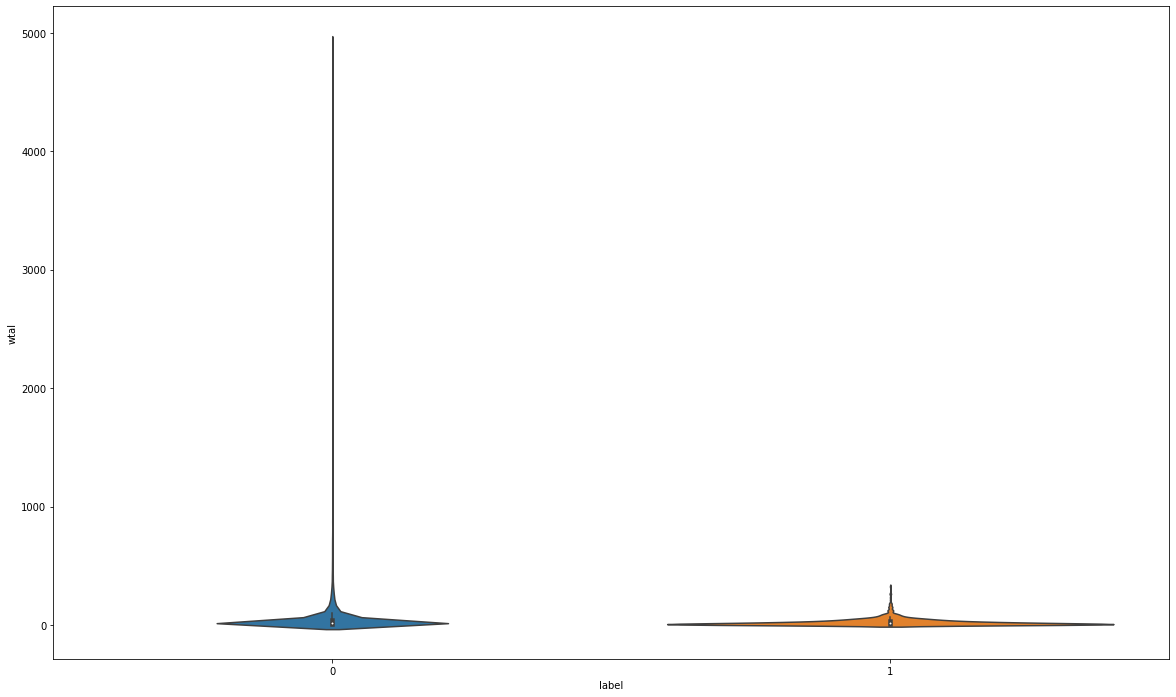

wtfe
AUC = 0.42468856140001604
max of class_1 = 305.6417494


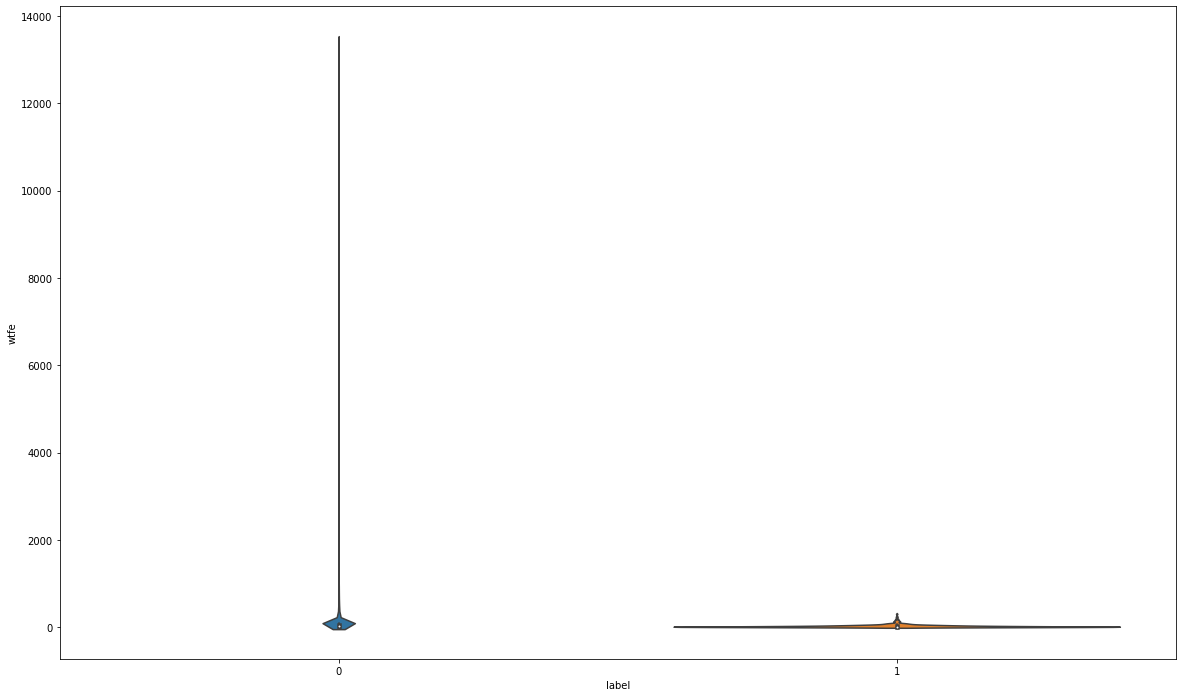

In [508]:
for c in wt_cols:
    print(c)
    print("AUC =",roc_auc_score(data_df["label"], data_df[c]))
    plt.figure(figsize=(20, 12))
#     f = sns.distplot(data_df[data_df.label == 0][c])
#     f2 = sns.distplot(data_df[data_df.label == 1][c])
    print("max of class_1 =", max(data_df[data_df.label == 1][c]))
    plt.show(sns.violinplot(data=data_df, y=c, x='label'))

#     plt.show(f, f2)

In [510]:
data_df[data_df.wtfe > 350].shape

(441, 17)

L1_raw
AUC = 0.4408249960324555


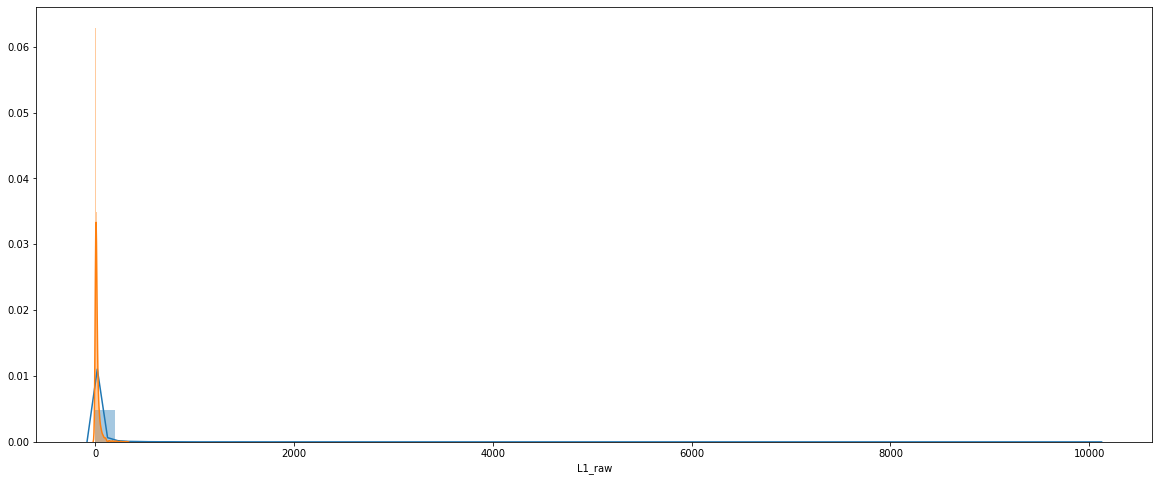

L2_log2fold
AUC = 0.5452438255293315


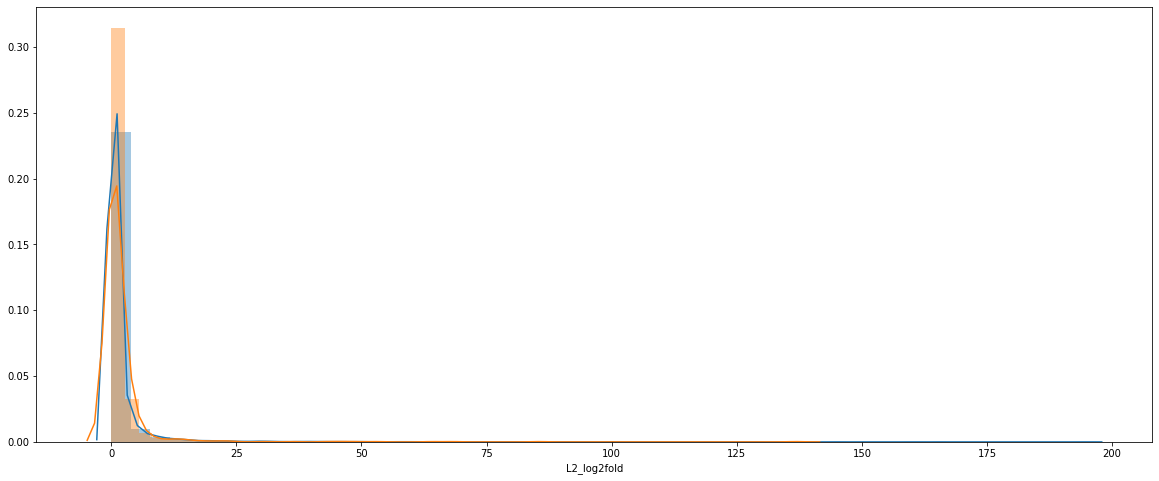

L2_noLog2
AUC = 0.543251124938031


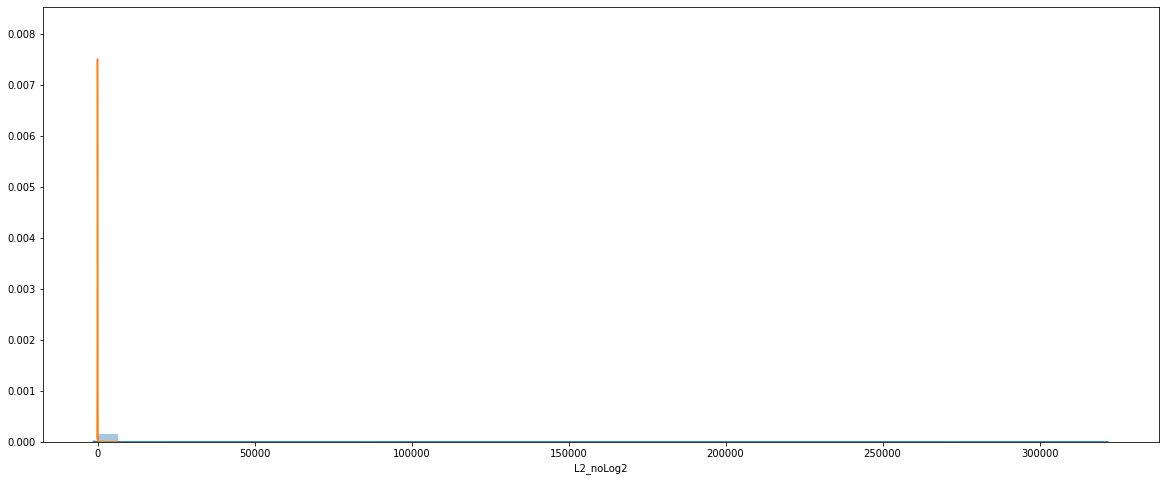

In [483]:
for c in ["L1_raw", "L2_log2fold", "L2_noLog2"]:
    print(c)
    print("AUC =",roc_auc_score(data_df["label"], data_df[c]))
    plt.figure(figsize=(20, 8))
    f = sns.distplot(data_df[data_df.label == 0][c])
    f2 = sns.distplot(data_df[data_df.label == 1][c])
    plt.show(f, f2)

In [455]:
data_df.label.value_counts()

0    19135
1     1197
Name: label, dtype: int64

In [456]:
data_df.shape

(20332, 9)

# Run with a threshold

## Pick the threshold

In [523]:
thres = 0.001

for c in wt_conditioned_cols:
    data_df[c+"_BIT"] = data_df.apply(lambda x: convert_to_up_down_noChange_3(x, thres, c, base_col), 1)

data_df["group_id"] = data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)

stats_data_df = data_df[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
stats_data_df["%TF"] = np.round(stats_data_df["#TF(s)"] * 100/stats_data_df["#genes"],2)
stats_data_df["group_id"] = stats_data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)
stats_data_df

,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,#genes,#TF(s),%TF,group_id
0,1,1,1,1,1,2896,143,4.94,11111
1,2,2,2,2,2,2797,186,6.65,22222
2,2,2,2,2,1,1922,102,5.31,22221
3,1,1,1,1,2,1673,49,2.93,11112
4,1,2,2,2,2,863,67,7.76,12222
5,1,1,1,2,2,858,68,7.93,11122
6,2,1,1,1,1,751,37,4.93,21111
7,2,2,2,1,1,692,52,7.51,22211
8,2,1,2,2,1,592,22,3.72,21221
9,2,2,2,1,2,575,40,6.96,22212


## Clutering

In [524]:

unique_groups = stats_data_df.group_id
DataFrameDict = dict()
summary = dict()
# sort_cols = ["L1_raw", "L2_raw", "L1_norm", "L2_norm"]
sort_cols = [ "L2_log2fold"]
# sort_cols = ["L1_noLog2"]

interesting_cols = ['atID', 'label'] + wt_cols + sort_cols


for sort_col in sort_cols:
    summary[sort_col] = dict()
    summary[sort_col]["num_tf"] = list()
    summary[sort_col]["percent_tf"] = list()
    summary[sort_col]["auc"] = list()
    
   
    
for key in unique_groups:
    DataFrameDict[key] = dict()
    DataFrameDict[key]["data"] = data_df[data_df.group_id == key].loc[:, interesting_cols]
    DataFrameDict[key]["result"] = dict()
    
    for sort_col in sort_cols:
        DataFrameDict[key]["result"][sort_col] = dict()
        tmp = DataFrameDict[key]["data"].sort_values(sort_col, ascending=True)
        total_tf_candidates =  stats_data_df[stats_data_df.group_id == key]["#TF(s)"].values[0]
        num_to_take = int(0.06 * tmp.shape[0])
        num_tf_candidates_in_the_top = tmp.head(num_to_take)["label"].sum()
        percent_tf_candidates_in_the_top = np.round(num_tf_candidates_in_the_top*100/total_tf_candidates,2)
        try:
            auc = roc_auc_score(tmp.label, tmp[sort_col].replace(np.inf, 9999))
            summary[sort_col]["auc"].append(auc)
            DataFrameDict[key]["result"][sort_col]['auc'] = auc
            
        except:
            auc = np.nan
            summary[sort_col]["auc"].append(auc)
            DataFrameDict[key]["result"][sort_col]['auc'] = auc

        summary[sort_col]["num_tf"].append(num_tf_candidates_in_the_top)
        summary[sort_col]["percent_tf"].append(percent_tf_candidates_in_the_top)
        
        DataFrameDict[key]["result"][sort_col]['num_tf'] = num_tf_candidates_in_the_top
        DataFrameDict[key]["result"][sort_col]['percent_tf'] = percent_tf_candidates_in_the_top
        

In [525]:
print("THRESHOLD = ", thres)
for sort_col in sort_cols:
    print("\t", sort_col)
    for key,val in summary[sort_col].items():
        print(f"{key}, {val}, sum is {np.nansum(val)}, mean is {np.nanmean(val)}", end="\n\n")
        
#         print(f"\t\t {key}: sum is {np.nansum(val, )}, mean is {np.nanmean(val)}", end="\n")
    
    print("\t\t---")
print("=============")

THRESHOLD =  0.001
	 L2_log2fold
num_tf, [10, 9, 5, 1, 1, 1, 2, 3, 3, 2, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], sum is 56, mean is 0.5233644859813084

percent_tf, [6.99, 4.84, 4.9, 2.04, 1.49, 1.47, 5.41, 5.77, 13.64, 5.0, 2.63, 3.23, 4.55, 6.67, 6.25, 4.35, 8.0, 0.0, 0.0, 4.55, 0.0, 7.14, 5.56, 5.26, 0.0, 0.0, 12.5, 9.09, 0.0, 0.0, 0.0, 27.27, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0], sum is 158.6, mean is 3.

## Show results

In [526]:
for sort_col in sort_cols:
    stats_data_df[sort_col + "_num_tf"] = summary[sort_col]["num_tf"]
    stats_data_df[sort_col + "_auc"] = summary[sort_col]["auc"]

    print(sort_col, "num_tf:", np.nanmedian ( stats_data_df[sort_col + "_num_tf"].sum()) )
    print(sort_col, "average auc:",np.nanmedian(stats_data_df[sort_col + "_auc"] ) )
    print("-----")

stats_data_df

L2_log2fold num_tf: 56.0
L2_log2fold average auc: 0.5625
-----


,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,#genes,#TF(s),%TF,group_id,L2_log2fold_num_tf,L2_log2fold_auc
0,1,1,1,1,1,2896,143,4.94,11111,10,0.58
1,2,2,2,2,2,2797,186,6.65,22222,9,0.50
2,2,2,2,2,1,1922,102,5.31,22221,5,0.51
3,1,1,1,1,2,1673,49,2.93,11112,1,0.57
4,1,2,2,2,2,863,67,7.76,12222,1,0.58
5,1,1,1,2,2,858,68,7.93,11122,1,0.63
6,2,1,1,1,1,751,37,4.93,21111,2,0.50
7,2,2,2,1,1,692,52,7.51,22211,3,0.44
8,2,1,2,2,1,592,22,3.72,21221,3,0.39
9,2,2,2,1,2,575,40,6.96,22212,2,0.50


In [527]:
2**0.2

1.148698354997035

## Show STOP1's cluster

In [528]:
sort_by = "L2_log2fold"
print("STOP1 is", STOP1)
group = data_df[data_df.atID == STOP1].group_id.values[0]
tmp = DataFrameDict[group]["data"].sort_values(sort_by).reset_index(drop=True)
print(tmp.shape)
tmp


STOP1 is AT1G34370
(692, 9)


,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe,L2_log2fold
0,AT5G13710,0,190.99,191.14,192.85,193.09,189.50,185.29,0.00
1,AT2G45200,0,40.59,40.67,40.88,41.24,39.16,38.45,0.01
2,AT1G08490,0,22.97,23.30,24.38,23.16,22.93,22.32,0.01
3,AT3G60250,0,63.82,64.19,65.07,68.32,63.69,62.07,0.01
4,AT3G07810,0,92.61,94.18,93.76,99.00,91.85,88.34,0.01
5,AT2G26270,0,9.14,9.30,9.48,9.33,8.85,8.57,0.02
6,AT5G44450,0,24.29,24.92,24.61,24.62,22.81,23.02,0.02
7,AT3G05870,0,10.54,10.66,10.73,10.61,9.94,9.85,0.02
8,AT1G62600,0,31.20,32.60,32.70,32.21,30.37,29.56,0.02
9,AT4G26610,0,34.58,36.83,36.41,35.80,32.89,33.87,0.02


In [529]:
data_df[data_df.atID == STOP1]

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe,L2_log2fold,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,group_id,L1_raw,L2_noLog2
2713,AT1G34370,1,130.39,152.46,131.31,137.00,121.74,129.71,0.07,2,2,2,1,1,22211,38.92,5.35


In [530]:
tmp_up_down = tmp[tmp.atID.isin(up_down_target_list)]
print(tmp_up_down.shape)
tmp_up_down

(5, 9)


,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe,L2_log2fold
345,AT5G05170,0,586.72,701.41,634.87,594.01,581.09,425.07,0.30
418,AT5G43310,0,36.98,41.49,39.26,40.04,33.90,24.65,0.41
505,AT5G64740,0,452.00,588.84,483.86,474.41,410.16,286.62,0.61
568,AT3G01810,0,46.46,59.96,55.66,53.90,40.07,27.57,0.86
571,AT2G26410,0,11.16,11.77,14.01,11.74,8.36,6.59,0.87


In [531]:
data_df[data_df.atID.isin(up_down_target_list)]

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe,L2_log2fold,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,group_id,L1_raw,L2_noLog2
15,AT1G01180,0,12.40,13.70,16.40,10.65,6.85,12.12,0.97,2,2,1,1,1,22111,12.88,4.97
16,AT1G01190,0,22.77,20.16,17.35,31.16,36.08,47.52,1.96,1,1,2,2,2,11222,54.47,10.10
224,AT1G03760,0,16.78,18.48,16.20,16.71,15.82,10.71,0.45,2,1,1,1,1,21111,9.38,4.43
330,AT1G04800,0,1.17,0.08,3.79,0.12,0.85,0.05,50.01,1,2,1,1,1,12111,6.21,10.97
351,AT1G05000,0,50.22,112.16,64.62,113.04,207.89,78.79,7.47,2,2,2,2,2,22222,325.40,31.31
369,AT1G05170,0,14.80,14.28,17.05,15.81,15.50,20.74,0.30,1,2,2,2,2,12222,10.44,6.46
502,AT1G06420,0,3.29,2.62,2.17,2.39,1.60,1.33,3.45,1,1,1,1,1,11111,6.32,2.00
527,AT1G06650,0,9.98,10.56,10.74,10.39,9.99,19.08,0.89,2,2,2,2,2,22222,10.84,8.01
712,AT1G08430,0,4.64,5.95,9.06,22.35,214.98,20.20,41.36,2,2,2,2,2,22222,249.36,2197.25
757,AT1G08840,0,13.85,18.35,17.74,21.61,16.79,15.33,0.80,2,2,2,2,2,22222,20.54,8.52


In [532]:
data_df[data_df.atID.isin(up_down_target_list)].groupby("group_id")["atID"].count().reset_index().rename(columns={"atID":"#genes"}).sort_values("#genes", ascending=False)

,group_id,#genes
28,22222,85
1,11111,41
14,12222,32
27,22221,17
15,21111,16
7,11222,13
20,21222,11
4,11122,8
18,21211,7
8,12111,6


# Run with many thresholds

In [520]:
def run_all(thres_list):
    summary_ALL = {}
    short_res = {}
    
    for sort_col in sort_cols:
        short_res[sort_col] = []
    
    for thres in thres_list:
        for c in wt_conditioned_cols:
            data_df[c+"_BIT"] = data_df.apply(lambda x: convert_to_up_down_noChange_2(x, thres, c, base_col), 1)

        data_df["group_id"] = data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)

        stats_data_df = data_df[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
        stats_data_df["%TF"] = np.round(stats_data_df["#TF(s)"] * 100/stats_data_df["#genes"],2)
        stats_data_df["group_id"] = stats_data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)
        
    
        
        unique_groups = stats_data_df.group_id
        DataFrameDict = dict()
        summary = dict()

        for sort_col in sort_cols:
            summary[sort_col] = dict()
            summary[sort_col]["num_tf"] = list()
            summary[sort_col]["percent_tf"] = list()
            summary[sort_col]["auc"] = list()


        for key in unique_groups:
            DataFrameDict[key] = dict()
            DataFrameDict[key]["data"] = data_df[data_df.group_id == key].loc[:, interesting_cols]
            DataFrameDict[key]["result"] = dict()

            for sort_col in sort_cols:
                DataFrameDict[key]["result"][sort_col] = dict()
                tmp = DataFrameDict[key]["data"].sort_values(sort_col, ascending=True)
                total_tf_candidates =  stats_data_df[stats_data_df.group_id == key]["#TF(s)"].values[0]
                num_tf_candidates_in_the_top = tmp.head(total_tf_candidates)["label"].sum()
                percent_tf_candidates_in_the_top = np.round(num_tf_candidates_in_the_top*100/total_tf_candidates,2)
                try:
                    auc = roc_auc_score(tmp.label, tmp[sort_col].replace(np.inf, 9999))
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                except:
                    auc = np.nan
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                summary[sort_col]["num_tf"].append(num_tf_candidates_in_the_top)
                summary[sort_col]["percent_tf"].append(percent_tf_candidates_in_the_top)

#                 DataFrameDict[key]["result"][sort_col]['num_tf'] = num_tf_candidates_in_the_top
#                 DataFrameDict[key]["result"][sort_col]['percent_tf'] = percent_tf_candidates_in_the_top
                
        summary_ALL[thres] = summary
        print("THRESHOLD = ", thres)
        for sort_col in sort_cols:
            print("\t", sort_col)
            for key,val in summary[sort_col].items():
                print(f"\t\t {key}: sum is {np.nansum(val, )}, mean is {np.nanmean(val)}", end="\n")
                
            short_res[sort_col].append(sum(summary[sort_col]["num_tf"]))

            print("\t\t---")
        print("=============")
    return summary_ALL, short_res

In [ ]:
thres_list = np.arange(1,2, 0.05)
summary_ALL_, short_res_ = run_all(thres_list)
short_res_

In [ ]:
for k, v in short_res_.items():
    print(k, np.amax(v))

In [ ]:
sns.barplot(x=thres_list, y=short_res_["L1_log2fold"])

In [ ]:
sns.barplot(x=thres_list, y=short_res_["L2_log2fold"])

In [ ]:
sns.barplot(x=thres_list, y=short_res_["L2_noFold"])

# Run many thresholds with leader percent

In [218]:
def run_all_with_percent(thres_list, leader_percent):
    summary_ALL = {}
    short_res = {}
    
    for sort_col in sort_cols:
        short_res[sort_col] = []
    
    for thres in thres_list:
        for c in wt_conditioned_cols:
            data_df[c+"_BIT"] = data_df.apply(lambda x: convert_to_up_down_noChange(x, thres, c, base_col), 1)

        data_df["group_id"] = data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)

        stats_data_df = data_df[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
        stats_data_df["%TF"] = np.round(stats_data_df["#TF(s)"] * 100/stats_data_df["#genes"],2)
        stats_data_df["group_id"] = stats_data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)
        
    
        
        unique_groups = stats_data_df.group_id
        DataFrameDict = dict()
        summary = dict()

        for sort_col in sort_cols:
            summary[sort_col] = dict()
            summary[sort_col]["num_tf"] = list()
            summary[sort_col]["percent_tf"] = list()
            summary[sort_col]["auc"] = list()


        for key in unique_groups:
            DataFrameDict[key] = dict()
            DataFrameDict[key]["data"] = data_df[data_df.group_id == key].loc[:, interesting_cols]
            DataFrameDict[key]["result"] = dict()

            for sort_col in sort_cols:
                DataFrameDict[key]["result"][sort_col] = dict()
                tmp = DataFrameDict[key]["data"].sort_values(sort_col, ascending=True)
#                 total_tf_candidates =  stats_data_df[stats_data_df.group_id == key]["#TF(s)"].values[0]
                num_tf_to_take = int(tmp.shape[0] * leader_percent) ## get x percent
                num_tf_candidates_in_the_top = tmp.head(num_tf_to_take)["label"].sum()
                percent_tf_candidates_in_the_top = np.round(num_tf_candidates_in_the_top*100/total_tf_candidates,2)
                try:
                    auc = roc_auc_score(tmp.label, tmp[sort_col].replace(np.inf, 9999))
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                except:
                    auc = np.nan
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                summary[sort_col]["num_tf"].append(num_tf_candidates_in_the_top)
                summary[sort_col]["percent_tf"].append(percent_tf_candidates_in_the_top)

#                 DataFrameDict[key]["result"][sort_col]['num_tf'] = num_tf_candidates_in_the_top
#                 DataFrameDict[key]["result"][sort_col]['percent_tf'] = percent_tf_candidates_in_the_top
                
        summary_ALL[thres] = summary
        print("THRESHOLD = ", thres)
        for sort_col in sort_cols:
            print("\t", sort_col)
            for key,val in summary[sort_col].items():
                print(f"\t\t {key}: sum is {np.nansum(val, )}, mean is {np.nanmean(val)}", end="\n")
                
            short_res[sort_col].append(sum(summary[sort_col]["num_tf"]))

            print("\t\t---")
        print("=============")
    return summary_ALL, short_res

In [219]:
0.06*17000

1020.0

In [220]:
leader_percent = 0.06
thres_list = np.arange(1, 3, 0.5)
summary_ALL_with_percent, short_res_with_percent = run_all_with_percent(thres_list, leader_percent)
short_res_with_percent

THRESHOLD =  1.0
	 L1_log2fold
		 num_tf: sum is 55, mean is 0.22727272727272727
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 102.94386462654771, mean is 0.5418098138239353
		---
	 L2_log2fold
		 num_tf: sum is 57, mean is 0.23553719008264462
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 102.48509501543587, mean is 0.5393952369233467
		---
	 L1_noLog2
		 num_tf: sum is 51, mean is 0.21074380165289255
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 0.0, mean is nan
		---
THRESHOLD =  1.5
	 L1_log2fold
		 num_tf: sum is 51, mean is 0.20987654320987653
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 96.84006521673335, mean is 0.5565520989467434
		---
	 L2_log2fold
		 num_tf: sum is 51, mean is 0.20987654320987653
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 96.50886751281153, mean is 0.554648663866733
		---
	 L1_noLog2
		 num_tf: sum is 47, mean is 0.1934156378600823
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 0.0, mean is nan
		---
THRESHOL

{'L1_log2fold': [55, 51, 45, 50],
 'L2_log2fold': [57, 51, 50, 51],
 'L1_noLog2': [51, 47, 49, 54]}

In [221]:
for k, v in short_res_with_percent.items():
    print(k, np.amax(v))

L1_log2fold 55
L2_log2fold 57
L1_noLog2 54


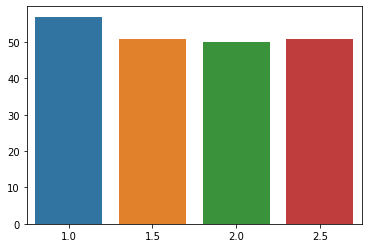

In [222]:
sns.barplot(x=thres_list, y=short_res_with_percent["L2_log2fold"])